In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from yahooquery import Ticker
import statsmodels.formula.api as smf

##### make sure files are in same directory

In [2]:
t_rates = pd.read_csv('data//Treasury-rates-20220517.csv')

In [20]:
t_rates

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2022-01-03,0.05,0.06,0.08,0.22,0.40,0.78,1.04,1.37,1.55,1.63,2.05,2.01
1,2022-01-04,0.06,0.05,0.08,0.22,0.38,0.77,1.02,1.37,1.57,1.66,2.10,2.07
2,2022-01-05,0.05,0.06,0.09,0.22,0.41,0.83,1.10,1.43,1.62,1.71,2.12,2.09
3,2022-01-06,0.04,0.05,0.10,0.23,0.45,0.88,1.15,1.47,1.66,1.73,2.12,2.09
4,2022-01-07,0.05,0.05,0.10,0.24,0.43,0.87,1.17,1.50,1.69,1.76,2.15,2.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2022-05-11,0.59,0.77,0.91,1.43,1.99,2.66,2.81,2.89,2.94,2.91,3.25,3.05
90,2022-05-12,0.61,0.77,0.96,1.44,1.96,2.56,2.73,2.81,2.86,2.84,3.22,3.00
91,2022-05-13,0.67,0.79,1.03,1.47,2.04,2.61,2.79,2.89,2.95,2.93,3.32,3.10
92,2022-05-16,0.64,0.85,1.07,1.54,2.07,2.58,2.75,2.83,2.89,2.88,3.30,3.09


In [4]:
t_rates.iloc[t_rates['3 Mo'].idxmax()]

Date     2022-05-16
1 Mo           0.64
2 Mo           0.85
3 Mo           1.07
6 Mo           1.54
1 Yr           2.07
2 Yr           2.58
3 Yr           2.75
5 Yr           2.83
7 Yr           2.89
10 Yr          2.88
20 Yr           3.3
30 Yr          3.09
Name: 92, dtype: object

In [5]:
rates = pd.DataFrame()
for  i in range(0,len(t_rates)):
    # selects row across each date
    rates_i= pd.DataFrame(t_rates.iloc[i][1:])
    rates_i.columns=['rates']
    rates_i=rates_i.reset_index()
    # get the integer value from time periods eg 1mo = 1
    rates_i['y'] = rates_i['index'].str.slice(0,2)
    rates_i['y']= rates_i['y'].astype(float)
    #finds where rates are less than 1 year and covert them into proper time period otherwise use the current time period
    rates_i['t']= np.where(rates_i.index<4,rates_i['y']/12,rates_i['y'])
    # repeats the date for each maturity
    rates_i['date'] = np.repeat(t_rates['Date'][i], 12, axis=0)
    rates_i=rates_i[['date' , 'index', 't', 'rates']]
    rates_i.columns= ['date' , 'maturities', 't', 'rate']
    rates = pd.concat([rates,rates_i])

In [9]:
rates.shape

(1128, 4)

In [7]:
rates_1 = rates[ rates['date'] < '2022-02-01']

In [8]:
rates_1.shape

(240, 4)

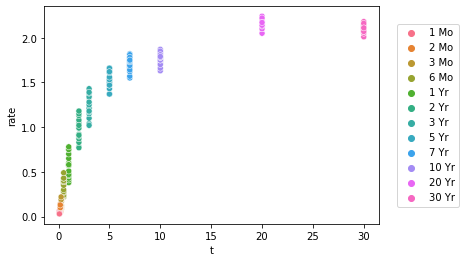

In [10]:
a = sns.scatterplot(x='t', y='rate', data =rates_1, hue ='maturities')
plt.legend(bbox_to_anchor=(1.0, .5) ,loc ='right',borderaxespad=-8)

In [11]:
rates_1['rate']=pd.to_numeric(rates_1['rate'])
rates_1.dropna()
rates_1.dtypes

C:\Users\shane\AppData\Local\Temp/ipykernel_17888/4068104504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates_1['rate']=pd.to_numeric(rates_1['rate'])


date           object
maturities     object
t             float64
rate          float64
dtype: object

In [12]:
from sklearn.linear_model import LinearRegression


In [13]:
X = rates_1[['t']]
y = rates_1[['rate']]

In [14]:
lm=LinearRegression()
X1 = sm.add_constant(X)
model1 = sm.OLS(y,X1).fit()
ypred1 = model1.predict(X1)

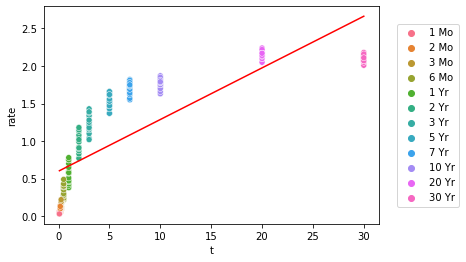

In [16]:
# how does linear reg fit the data
a = sns.scatterplot(x='t', y='rate', data =rates_1, hue ='maturities')
plt.legend(bbox_to_anchor=(1.0, .5) ,loc ='right',borderaxespad=-8)
plt.plot(X,ypred1, c= 'red')

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)
model2 =sm.OLS(y,X_poly).fit()
ypred2 = model2.predict(X_poly)

In [18]:
y_pred =np.array([1,12,144])
model2.predict(y_pred)

array([2.13357386])

In [232]:
np.array(model2.summary())

array(<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1061.
Date:                Mon, 30 May 2022   Prob (F-statistic):          5.45e-119
Time:                        15:17:31   Log-Likelihood:                -2.7540
No. Observations:                 240   AIC:                             11.51
Df Residuals:                     237   BIC:                             21.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

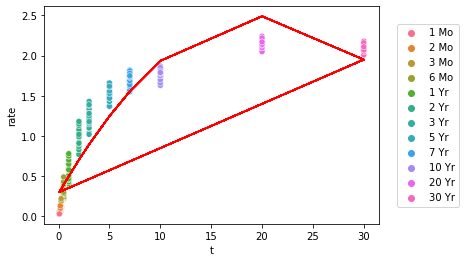

In [233]:
# how poly reg fits the data
a = sns.scatterplot(x='t', y='rate', data =rates_1, hue ='maturities')
plt.legend(bbox_to_anchor=(1.0, .5) ,loc ='right',borderaxespad=-8)
plt.plot(X,ypred2, c= 'red')

In [234]:
data_tech = pd.read_csv('data//tech_sector_5m_20220519.csv', usecols =['symbol', 'date', 'close', 'volume'])

In [235]:
data_tech.shape

(39312, 4)

In [236]:
data_tech.dtypes

symbol     object
date       object
volume      int64
close     float64
dtype: object

In [237]:
data_tech['date']= pd.to_datetime(data_tech['date'])
data_tech['day']= data_tech['date'].dt.date
data_tech['minute'] = ((data_tech['date'] - data_tech['date'].dt.normalize()) / pd.Timedelta('1 minute')).astype(int)
data_tech.head()

,symbol,date,volume,close,day,minute
0,SPY,2022-03-21 09:30:00,4363511,445.790009,2022-03-21,570
1,SPY,2022-03-21 09:35:00,2008084,446.260010,2022-03-21,575
2,SPY,2022-03-21 09:40:00,1324533,445.839996,2022-03-21,580
3,SPY,2022-03-21 09:45:00,1577899,444.989990,2022-03-21,585
4,SPY,2022-03-21 09:50:00,1540934,443.920013,2022-03-21,590


In [238]:
symbols= data_tech['symbol'].unique()
stks=list( symbols[2:])
stks


['AAPL', 'MSFT', 'NVDA', 'V', 'PYPL', 'MA', 'ADBE', 'INTC', 'CRM', 'CSCO']

In [239]:
data1 = data_tech[data_tech['symbol'].isin(stks)]
data1.head()

,symbol,date,volume,close,day,minute
6552,AAPL,2022-03-21 09:30:00,4030270,164.070007,2022-03-21,570
6553,AAPL,2022-03-21 09:35:00,2031681,165.009995,2022-03-21,575
6554,AAPL,2022-03-21 09:40:00,1637002,165.339996,2022-03-21,580
6555,AAPL,2022-03-21 09:45:00,1497955,165.024994,2022-03-21,585
6556,AAPL,2022-03-21 09:50:00,1863647,163.990005,2022-03-21,590


In [240]:
data1[(data1['symbol'] == 'CSCO') & (data1['day'] != '2022-05-18')]
data1.tail()

,symbol,date,volume,close,day,minute
39307,CSCO,2022-05-18 15:35:00,493278,48.615002,2022-05-18,935
39308,CSCO,2022-05-18 15:40:00,694958,48.529999,2022-05-18,940
39309,CSCO,2022-05-18 15:45:00,1138759,48.330002,2022-05-18,945
39310,CSCO,2022-05-18 15:50:00,1206911,48.330002,2022-05-18,950
39311,CSCO,2022-05-18 15:55:00,2550993,48.590000,2022-05-18,955


In [59]:
data = pd.read_csv('data//tech_sector_5m_20220519.csv')
data

,Unnamed: 0,symbol,date,volume,close,day,minute
0,0,SPY,2022-03-21 09:30:00,4363511,445.790009,2022-03-21,570
1,1,SPY,2022-03-21 09:35:00,2008084,446.260010,2022-03-21,575
2,2,SPY,2022-03-21 09:40:00,1324533,445.839996,2022-03-21,580
3,3,SPY,2022-03-21 09:45:00,1577899,444.989990,2022-03-21,585
4,4,SPY,2022-03-21 09:50:00,1540934,443.920013,2022-03-21,590
...,...,...,...,...,...,...,...
39307,39307,CSCO,2022-05-18 15:35:00,493278,48.615002,2022-05-18,935
39308,39308,CSCO,2022-05-18 15:40:00,694958,48.529999,2022-05-18,940
39309,39309,CSCO,2022-05-18 15:45:00,1138759,48.330002,2022-05-18,945
39310,39310,CSCO,2022-05-18 15:50:00,1206911,48.330002,2022-05-18,950


In [60]:
data.columns

Index(['Unnamed: 0', 'symbol', 'date', 'volume', 'close', 'day', 'minute'], dtype='object')

In [61]:
stocks = pd.DataFrame(data)
stocks.head()

,Unnamed: 0,symbol,date,volume,close,day,minute
0,0,SPY,2022-03-21 09:30:00,4363511,445.790009,2022-03-21,570
1,1,SPY,2022-03-21 09:35:00,2008084,446.260010,2022-03-21,575
2,2,SPY,2022-03-21 09:40:00,1324533,445.839996,2022-03-21,580
3,3,SPY,2022-03-21 09:45:00,1577899,444.989990,2022-03-21,585
4,4,SPY,2022-03-21 09:50:00,1540934,443.920013,2022-03-21,590


In [62]:
stocks['close_lag1']= stocks.groupby(['symbol','day'])['close'].shift(1)
stocks['close_lead1']= stocks.groupby(['symbol','day'])['close'].shift(-1)
# Calculate netxt return
stocks['next_ret'] = stocks['close']/stocks['close_lead1'] -1
## Calculate returns and agged returns
stocks['ret'] = stocks['close']/stocks['close_lag1'] -1
stocks['prev1_ret']= stocks.groupby('day')['ret'].shift(1)
stocks['prev2_ret']= stocks.groupby('day')['prev1_ret'].shift(1)
stocks['prev3_ret']= stocks.groupby('day')['prev2_ret'].shift(1)
stocks['prev4_ret']= stocks.groupby('day')['prev3_ret'].shift(1)
## Calculate Money flow
stocks['money_flow'] = stocks['volume']*stocks['ret']
stocks['prev1_money_flow']= stocks.groupby(['symbol','day'])['money_flow'].shift(1)
stocks['prev2_money_flow']= stocks.groupby(['symbol','day'])['prev1_money_flow'].shift(1)
stocks['prev3_money_flow']= stocks.groupby(['symbol','day'])['prev2_money_flow'].shift(1)
stocks['prev4_money_flow']= stocks.groupby(['symbol','day'])['prev3_money_flow'].shift(1)
stocks['prev5_money_flow']= stocks.groupby(['symbol','day'])['prev4_money_flow'].shift(1)
stocks = stocks[[ 'day', 'minute', 'next_ret', 'ret',
       'prev1_ret', 'prev2_ret', 'prev3_ret', 'prev4_ret',
       'money_flow', 'prev1_money_flow', 'prev2_money_flow',
       'prev3_money_flow', 'prev4_money_flow', 'prev5_money_flow' ]]

In [63]:
spy = data[data['symbol'] == 'SPY']
spy['close_lag1']= spy.groupby('day')['close'].shift(1)
spy['close_lead1']= spy.groupby('day')['close'].shift(-1)
# Calculate netxt return
spy['spy_next_ret'] = spy['close']/spy['close_lead1'] -1
## Calculate returns and agged returns
spy['spy_ret'] = spy['close']/spy['close_lag1'] -1
spy['spy_prev1_ret']= spy.groupby('day')['spy_ret'].shift(1)
spy['spy_prev2_ret']= spy.groupby('day')['spy_prev1_ret'].shift(1)
spy['spy_prev3_ret']= spy.groupby('day')['spy_prev2_ret'].shift(1)
spy['spy_prev4_ret']= spy.groupby('day')['spy_prev3_ret'].shift(1)
## Calculate Money flow
spy['spy_money_flow'] = spy['volume']*spy['spy_ret']
spy['spy_prev1_money_flow']= spy.groupby('day')['spy_money_flow'].shift(1)
spy['spy_prev2_money_flow']= spy.groupby('day')['spy_prev1_money_flow'].shift(1)
spy['spy_prev3_money_flow']= spy.groupby('day')['spy_prev2_money_flow'].shift(1)
spy['spy_prev4_money_flow']= spy.groupby('day')['spy_prev3_money_flow'].shift(1)
spy['spy_prev5_money_flow']= spy.groupby('day')['spy_prev4_money_flow'].shift(1)
spy = spy[[ 'day', 'minute', 'spy_next_ret', 'spy_ret',
       'spy_prev1_ret', 'spy_prev2_ret', 'spy_prev3_ret', 'spy_prev4_ret',
       'spy_money_flow', 'spy_prev1_money_flow', 'spy_prev2_money_flow',
       'spy_prev3_money_flow', 'spy_prev4_money_flow', 'spy_prev5_money_flow' ]]

C:\Users\shane\AppData\Local\Temp/ipykernel_17888/1312156019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy['close_lag1']= spy.groupby('day')['close'].shift(1)
C:\Users\shane\AppData\Local\Temp/ipykernel_17888/1312156019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy['close_lead1']= spy.groupby('day')['close'].shift(-1)
C:\Users\shane\AppData\Local\Temp/ipykernel_17888/1312156019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [64]:
xlk = data[data.symbol == 'XLK']
xlk['close_lag1']= xlk.groupby('day')['close'].shift(1)
xlk['close_lead1']= xlk.groupby('day')['close'].shift(-1)
# Calculate netxt return
xlk['xlk_next_ret'] = xlk['close'] / xlk['close_lead1'] - 1
## Calculate returns and agged returns
xlk['xlk_ret'] = xlk['close'] / xlk['close_lag1'] - 1
xlk['xlk_prev1_ret']= xlk.groupby('day')['xlk_ret'].shift(1)
xlk['xlk_prev2_ret']= xlk.groupby('day')['xlk_prev1_ret'].shift(1)
xlk['xlk_prev3_ret']= xlk.groupby('day')['xlk_prev2_ret'].shift(1)
xlk['xlk_prev4_ret']= xlk.groupby('day')['xlk_prev3_ret'].shift(1)
## Calculate Money flow
xlk['xlk_money_flow'] = xlk['volume'] * xlk['xlk_ret']
xlk['xlk_prev1_money_flow']= xlk.groupby('day')['xlk_money_flow'].shift(1)
xlk['xlk_prev2_money_flow']= xlk.groupby('day')['xlk_prev1_money_flow'].shift(1)
xlk['xlk_prev3_money_flow']= xlk.groupby('day')['xlk_prev2_money_flow'].shift(1)
xlk['xlk_prev4_money_flow']= xlk.groupby('day')['xlk_prev3_money_flow'].shift(1)
xlk['xlk_prev5_money_flow']= xlk.groupby('day')['xlk_prev4_money_flow'].shift(1)
xlk = xlk[['day', 'minute', 'xlk_next_ret', 'xlk_ret',
       'xlk_prev1_ret', 'xlk_prev2_ret', 'xlk_prev3_ret', 'xlk_prev4_ret',
       'xlk_money_flow', 'xlk_prev1_money_flow', 'xlk_prev2_money_flow',
       'xlk_prev3_money_flow', 'xlk_prev4_money_flow', 'xlk_prev5_money_flow']]
xlk.columns

C:\Users\shane\AppData\Local\Temp/ipykernel_17888/2170491520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xlk['close_lag1']= xlk.groupby('day')['close'].shift(1)
C:\Users\shane\AppData\Local\Temp/ipykernel_17888/2170491520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xlk['close_lead1']= xlk.groupby('day')['close'].shift(-1)
C:\Users\shane\AppData\Local\Temp/ipykernel_17888/2170491520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Index(['day', 'minute', 'xlk_next_ret', 'xlk_ret', 'xlk_prev1_ret',
       'xlk_prev2_ret', 'xlk_prev3_ret', 'xlk_prev4_ret', 'xlk_money_flow',
       'xlk_prev1_money_flow', 'xlk_prev2_money_flow', 'xlk_prev3_money_flow',
       'xlk_prev4_money_flow', 'xlk_prev5_money_flow'],
      dtype='object')

In [65]:
stocks1 = pd.merge(stocks,spy, on=['day', 'minute'], how='left' )
stocks= pd.merge(stocks1, xlk, on=['day', 'minute'], how='left')

In [66]:
stocks = stocks.dropna()

In [68]:
stocks['x0']=1
vars0= ['x0' ,
        'spy_ret','spy_prev1_ret', 'spy_prev2_ret', 'spy_prev3_ret', 'spy_prev4_ret',
       'spy_prev4_ret','spy_money_flow', 'spy_prev1_money_flow', 'spy_prev2_money_flow',
       'spy_prev3_money_flow', 'spy_prev4_money_flow', 'spy_prev5_money_flow',

       'xlk_prev4_ret','xlk_ret', 'xlk_prev1_ret','xlk_prev2_ret', 'xlk_prev3_ret', 'xlk_prev4_ret',
        'xlk_money_flow', 'xlk_prev1_money_flow', 'xlk_prev2_money_flow',
        'xlk_prev3_money_flow','xlk_prev4_money_flow', 'xlk_prev5_money_flow' ,

        'ret', 'prev1_ret', 'prev2_ret', 'prev3_ret', 'prev4_ret',
        'prev4_ret', 'money_flow','prev1_money_flow', 'prev2_money_flow',
        'prev3_money_flow','prev4_money_flow', 'prev5_money_flow'
       ]

In [69]:
stocks

,day,minute,next_ret,ret,prev1_ret,prev2_ret,prev3_ret,prev4_ret,money_flow,prev1_money_flow,...,xlk_prev2_ret,xlk_prev3_ret,xlk_prev4_ret,xlk_money_flow,xlk_prev1_money_flow,xlk_prev2_money_flow,xlk_prev3_money_flow,xlk_prev4_money_flow,xlk_prev5_money_flow,x0
6,2022-03-21,600,-0.000045,-0.000874,0.000063,-0.002404,-0.001907,-0.000941,-929.561420,78.458299,...,-0.004474,-0.004840,0.001422,-383.010743,22.929684,-845.618739,-810.857606,221.339077,237.625372,1
7,2022-03-21,605,0.000361,0.000045,-0.000874,0.000063,-0.002404,-0.001907,54.872448,-929.561420,...,0.000130,-0.004474,-0.004840,12.413011,-383.010743,22.929684,-845.618739,-810.857606,221.339077,1
8,2022-03-21,610,-0.000248,-0.000361,0.000045,-0.000874,0.000063,-0.002404,-388.492258,54.872448,...,-0.002019,0.000130,-0.004474,-147.997803,12.413011,-383.010743,22.929684,-845.618739,-810.857606,1
9,2022-03-21,615,0.000496,0.000248,-0.000361,0.000045,-0.000874,0.000063,240.964449,-388.492258,...,0.000065,-0.002019,0.000130,-12.516775,-147.997803,12.413011,-383.010743,22.929684,-845.618739,1
10,2022-03-21,620,0.000722,-0.000496,0.000248,-0.000361,0.000045,-0.000874,-450.209114,240.964449,...,-0.001305,0.000065,-0.002019,-164.801012,-12.516775,-147.997803,12.413011,-383.010743,22.929684,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39306,2022-05-18,930,-0.004525,0.001449,0.000310,-0.001550,0.000000,-0.001548,619.738830,97.007642,...,-0.001665,0.000833,-0.000303,54.451139,0.000000,-380.262386,108.015670,-44.136601,17.149483,1
39307,2022-05-18,935,0.001752,0.004546,0.001449,0.000310,-0.001550,0.000000,2242.416802,619.738830,...,0.000000,-0.001665,0.000833,1258.526453,54.451139,0.000000,-380.262386,108.015670,-44.136601,1
39308,2022-05-18,940,0.004138,-0.001748,0.004546,0.001449,0.000310,-0.001550,-1215.127898,2242.416802,...,0.000227,0.000000,-0.001665,-572.583889,1258.526453,54.451139,0.000000,-380.262386,108.015670,1
39309,2022-05-18,945,0.000000,-0.004121,-0.001748,0.004546,0.001449,0.000310,-4692.939017,-1215.127898,...,0.004243,0.000227,0.000000,-271.631007,-572.583889,1258.526453,54.451139,0.000000,-380.262386,1


In [70]:
X0= stocks[vars0]
Y = stocks['next_ret']

In [72]:
model3 = sm.OLS(Y,X0).fit()

In [73]:
stocks['pred0'] = model3.predict(X0) # make the predictions by the model
np.array(model3.summary())

array(<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:               next_ret   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     13.43
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           8.92e-73
Time:                        20:22:25   Log-Likelihood:             1.6805e+05
No. Observations:               35784   AIC:                        -3.360e+05
Df Residuals:                   35750   BIC:                        -3.357e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [74]:
stocks_train = stocks[pd.to_datetime(stocks['day']) < '2022-04-30']
stocks_test = stocks[pd.to_datetime(stocks['day']) > '2022-04-30']
stocks_train=stocks_train.dropna()
stocks_test=stocks_test.dropna()

In [76]:
x_train = stocks_train[vars0]
x_test  = stocks_test[vars0]
y_train= stocks_train['next_ret']
y_test = stocks_test['next_ret']

In [77]:
lm0 = sm.OLS(y_train, x_train).fit()
stocks_train['in_pred0'] = lm0.predict(x_train)
stocks_test['out_pred0'] = lm0.predict(x_test)
np.array(lm0.summary())

array(<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:               next_ret   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.503
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           2.38e-28
Time:                        20:27:51   Log-Likelihood:             1.1998e+05
No. Observations:               24708   AIC:                        -2.399e+05
Df Residuals:                   24674   BIC:                        -2.396e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [78]:
stocks_train['next_ret'].corr(stocks_train['in_pred0'])

0.09285497473935758

In [80]:
stocks_test['next_ret'].corr(stocks_test['out_pred0'])

0.05529369485678101

In [81]:
!pip install mlxtend

In [88]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

sfs = SFS(lr,
          k_features=10,
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv= 0)

In [89]:
sfs = sfs.fit(X0, Y)
out= sfs.get_metric_dict()
sfs.get_metric_dict()

C:\Users\shane\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\shane\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{1: {'feature_idx': (19,),
  'cv_scores': array([-4.93436345e-06]),
  'avg_score': -4.9343634542603546e-06,
  'feature_names': ('xlk_money_flow',),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 2: {'feature_idx': (7, 19),
  'cv_scores': array([-4.91481049e-06]),
  'avg_score': -4.914810486154993e-06,
  'feature_names': ('spy_money_flow', 'xlk_money_flow'),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 3: {'feature_idx': (1, 7, 19),
  'cv_scores': array([-4.90786948e-06]),
  'avg_score': -4.907869482174074e-06,
  'feature_names': ('spy_ret', 'spy_money_flow', 'xlk_money_flow'),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 4: {'feature_idx': (1, 4, 7, 19),
  'cv_scores': array([-4.90526126e-06]),
  'avg_score': -4.905261261545558e-06,
  'feature_names': ('spy_ret',
   'spy_prev3_ret',
   'spy_money_flow',
   'xlk_money_flow'),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 5: {'feature_idx': (1, 4, 7, 19, 34),
  'cv_scores': array([-4.90284957e

In [107]:
vars1= list ( out[10]['feature_names'] )
vars1

['spy_ret',
 'spy_prev3_ret',
 'spy_money_flow',
 'spy_prev4_money_flow',
 'spy_prev5_money_flow',
 'xlk_prev1_ret',
 'xlk_money_flow',
 'xlk_prev1_money_flow',
 'xlk_prev4_money_flow',
 'prev3_money_flow']

In [108]:
x_train = stocks_train[vars1]
x_test  = stocks_test[vars1]
y_train= stocks_train['next_ret']
y_test = stocks_test['next_ret']

In [109]:
lm1 = sm.OLS(y_train, x_train).fit()
stocks_train['in_pred1'] = lm1.predict(x_train)
stocks_test['out_pred1'] = lm1.predict(x_test)
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               next_ret   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              5.863
Date:                Thu, 02 Jun 2022   Prob (F-statistic):                    6.74e-09
Time:                        21:01:54   Log-Likelihood:                      1.1990e+05
No. Observations:               24708   AIC:                                 -2.398e+05
Df Residuals:                   24698   BIC:                                 -2.397e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
spy_ret                  0.0419      0.018      2.268      0.023       0.006       0.078
spy_prev3_ret           -0.0329      0.013     -2.505      0.012      -0.059      -0.007
spy_money_flow        2.804e-08   1.37e-08      2.053      0.040    1.27e-09    5.48e-08
spy_prev4_money_flow  2.359e-08   1.31e-08      1.803      0.071   -2.06e-09    4.92e-08
spy_prev5_money_flow -7.527e-09   8.03e-09     -0.937      0.349   -2.33e-08    8.22e-09
xlk_prev1_ret           -0.0568      0.015     -3.715      0.000      -0.087      -0.027
xlk_money_flow       -3.414e-07   6.85e-08     -4.986      0.000   -4.76e-07   -2.07e-07
xlk_prev1_money_flow  2.324e-07   8.24e-08      2.822      0.005     7.1e-08    3.94e-07
xlk_prev4_money_flow -1.212e-07    7.2e-08     -1.685      0.092   -2.62e-07    1.98e-08
prev3_money_flow       3.14e-08   9.68e-09      3.242      0.001    1.24e-08    5.04e-08
==============================================================================
Omnibus:                     2595.070   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22707.845
Skew:                          -0.059   Prob(JB):                         0.00
Kurtosis:                       7.695   Cond. No.                     2.87e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
stocks_train['next_ret'].corr(stocks_train['in_pred1'])

0.04848559908502434

In [111]:
stocks_test['next_ret'].corr(stocks_test['out_pred1'])

0.1305013506827604

In [112]:
x_train = stocks_train[vars0]
x_test  = stocks_test[vars0]
y_train= stocks_train['next_ret']
y_test = stocks_test['next_ret']

In [113]:
model1 = sm.OLS(y_train, x_train).fit_regularized(alpha=0.0001, L1_wt=0)
stocks_train['in_LASSO'] = model1.predict(x_train)
stocks_test['out_LASSO'] = model1.predict(x_test)

r_in_LASSO= stocks_train['next_ret'].corr(stocks_train['in_LASSO'])
r_out_LASSO= stocks_test['next_ret'].corr(stocks_test['out_LASSO'])
print ('in-sample LASSO r = ', r_in_LASSO, 'out-of-sample LASSO r= ', r_out_LASSO)
model1.params[model1.params > 0.000001]

in-sample LASSO r =  0.0634562344338466 out-of-sample LASSO r=  0.05287446283580775


array([4.33603627e-05, 1.42483691e-04, 1.65918306e-04, 1.53414064e-04,
       2.50296960e-05, 1.04937003e-04])

In [116]:
model1 = sm.OLS(y_train, x_train).fit_regularized(alpha=0.0001, L1_wt=1)
stocks_train['in_ridge'] = model1.predict(x_train)
stocks_test['out_ridge'] = model1.predict(x_test)

r_in_LASSO= stocks_train['next_ret'].corr(stocks_train['in_ridge'])
r_out_LASSO= stocks_test['next_ret'].corr(stocks_test['out_ridge'])
print ('in-sample ridge r = ', r_in_LASSO, 'out-of-sample ridge r= ', r_out_LASSO)
model1.params.columns= ['beta']
model1.params[model1.params>0]

in-sample ridge r =  0.056583724445351216 out-of-sample ridge r=  0.04829429740767971


spy_prev4_money_flow    1.753984e-08
xlk_prev2_money_flow    1.611628e-07
xlk_prev5_money_flow    2.176366e-07
money_flow              5.187881e-08
prev3_money_flow        3.521177e-08
dtype: float64

In [121]:
model1 = sm.OLS(y_train, x_train).fit_regularized(alpha=0.0001, L1_wt=.50)
stocks_train['in_LASSO'] = model1.predict(x_train)
stocks_test['out_LASSO'] = model1.predict(x_test)

r_in_LASSO= stocks_train['next_ret'].corr(stocks_train['in_LASSO'])
r_out_LASSO= stocks_test['next_ret'].corr(stocks_test['out_LASSO'])
print ('in-sample LASSO r = ', r_in_LASSO, 'out-of-sample LASSO r= ', r_out_LASSO)
model1.params[model1.params > 0.000001]
model1.params[model1.params>0]

in-sample LASSO r =  0.056584501849412425 out-of-sample LASSO r=  0.048186582138970674


spy_prev4_money_flow    1.781371e-08
xlk_prev2_money_flow    1.622090e-07
xlk_prev5_money_flow    2.192492e-07
money_flow              5.199170e-08
prev3_money_flow        3.532251e-08
dtype: float64

In [122]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [123]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [124]:
regressor.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [125]:
in_sample_randF_r = regressor.predict(x_train)
out_sample_randF_r = regressor.predict(x_test)